
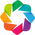

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import holoviews as hv
hv.extension('bokeh')
from database.db_queries import get_all_resampled_data


In [2]:
import talib as tl

In [3]:
usd_open = get_all_resampled_data(currency='EURUSD', frequency='D', begin='1970', end='2020', pricetype='open')
usd_high = get_all_resampled_data(currency='EURUSD', frequency='D', begin='1970', end='2020', pricetype='high')
usd_low = get_all_resampled_data(currency='EURUSD', frequency='D', begin='1970', end='2020', pricetype='low')
usd_close = get_all_resampled_data(currency='EURUSD', frequency='D', begin='1970', end='2020', pricetype='close')
usd_data = pd.concat([usd_open, usd_high,usd_low,usd_close], axis=1)

Got 12 EURUSD-D-open documents
Got 12 EURUSD-D-high documents
Got 12 EURUSD-D-low documents
Got 12 EURUSD-D-close documents


In [4]:
%output size=100
%opts Curve  [height=400 width=400 xaxis='bottom' tools=['hover','xbox_select']]
%opts Curve ( line_width=.5)
%opts Scatter  [height=400 width=400 xaxis='bottom' tools=['hover']]
%opts Spikes  [height=400 width=400 xaxis='bottom' tools=['hover']]
%opts Histogram  [height=400 width=400 xaxis='bottom' tools=['hover']] (alpha=0.5)

In [5]:
close = usd_close['close'].values

In [6]:
upperband, middleband, lowerband = tl.BBANDS(close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)

In [7]:
bol=pd.DataFrame()
bol['date']=usd_data.index.values
bol['close']=usd_data['close'].values
bol['upper']=upperband
bol['mid']=middleband
bol['low']=lowerband
bol.head(10)

,date,close,upper,mid,low
0,2004-01-02,1.2591,NaN,NaN,NaN
1,2004-01-04,1.2637,NaN,NaN,NaN
2,2004-01-05,1.2687,NaN,NaN,NaN
3,2004-01-06,1.2721,NaN,NaN,NaN
4,2004-01-07,1.2642,1.274490,1.26556,1.256630
5,2004-01-08,1.2773,1.279379,1.26920,1.259021
6,2004-01-09,1.2836,1.286669,1.27318,1.259691
7,2004-01-11,1.2853,1.291970,1.27650,1.261030
8,2004-01-12,1.2741,1.291993,1.27690,1.261807
9,2004-01-13,1.2789,1.288049,1.27984,1.271631


In [8]:
curve_dict = {col:hv.Curve((bol['date'], bol[col]), kdims=['date'], group=col) for col in ['close', 'upper', 'mid', 'low']}

In [9]:
ndoverlay = hv.NdOverlay(curve_dict, kdims=['datexxx'])

In [10]:
%%opts Curve  [height=400 width=900 xaxis='bottom' tools=['hover','xbox_select'] show_grid=True]
%%opts Curve ( line_width=.5)
%%opts Curve.close (line_width=1, color='red')
ndoverlay

:NdOverlay   [datexxx]
   :Curve   [date]   (y)

In [11]:
curve_bol = hv.Curve((bol['date'], (bol['close']-bol['mid'])/bol['close']), kdims=['date'], vdims=['closex'] )

In [12]:
%%opts Curve  [height=400 width=900 xaxis='bottom' tools=['hover','xbox_select'] show_grid=True]
# %%opts Layout [shared_axes=True shared_datasource=True]
%%opts Curve ( line_width=.5)

(ndoverlay + curve_bol).cols(1)

:Layout
   .Close.I :NdOverlay   [datexxx]
      :Curve   [date]   (y)
   .Curve.I :Curve   [date]   (closex)

In [13]:
%%opts Curve  [height=400 width=600 xaxis='bottom' tools=['hover'] show_grid=True]
sig = (bol['close']-bol['mid'])/bol['close']
sig.dropna(inplace=True)
frequencies, edges = np.histogram(sig, 50, density=True)
hist_bol = hv.Histogram(frequencies ,edges, kdims=['closex']) 

In [14]:
curve_bol <<  hist_bol

:AdjointLayout
   :Curve   [date]   (closex)
   :Histogram   [closex]   (Frequency)

In [15]:
from scipy.stats import norm

In [16]:
# Fit a normal distribution to the data:
mu, std = norm.fit(sig)
print mu, std
# Calc the PDF.
xmin, xmax = sig.min(), sig.max()
x = np.linspace(xmin, xmax, 3700)
fit_norm = norm.pdf(x, loc=mu, scale=std)
xmin,xmax,fit_norm.max()

-0.000114554452164 0.00644343186385


(-0.033015028177834041, 0.042365352581898316, 61.914498470273784)

In [17]:
%%opts Scatter.FitNorm (line_width=1, color='red')
hist_norm = hv.Scatter((x,fit_norm), group='FitNorm')
hist_norm


:Scatter   [x]   (y)

In [18]:
hist_norm * hist_bol

:Overlay
   .FitNorm.I   :Scatter   [x]   (y)
   .Histogram.I :Histogram   [closex]   (Frequency)